In [1]:
import hifi_gan
import torch

In [2]:
import g2p_en

In [3]:
g2p = g2p_en.G2p()

In [4]:
import re

def to_arpabet(g2p, text):
    """Convert a sentence in english to arpabet."""
    g2p_out = g2p(text)
    current = 0
    current_tokens = []
    current_token_is_punc = False
    output = []
    while True:
        if current >= len(g2p_out) or g2p_out[current] == " ":
            if current_token_is_punc:
                output.append("".join(current_tokens))
            else:
                output.append("{%s}" % (" ".join(current_tokens)))
            current_tokens = []
            if current >= len(g2p_out):
                break
        else:
            if len(current_tokens) == 0:
                current_token_is_punc = (
                    re.match(r"[,'\-!\.?]+", g2p_out[current]) is not None
                )
            current_tokens.append(g2p_out[current])
        current += 1

    return " ".join(output)

In [5]:
import os
import json
import hifi_gan
from hifi_gan.env import AttrDict
from hifi_gan.inference_e2e import load_checkpoint
from hifi_gan.meldataset import MAX_WAV_VALUE
from hifi_gan.models import Generator

def load_hifi_gan(path, device="cpu"):
    dev = torch.device(device)
    with open(os.path.join(path, "config.json"), "r") as f:
        config = AttrDict(json.load(f))
    generator = Generator(config).to(dev)
    for file in os.listdir(path):
        if file.startswith("g_"):
            gen_filename = file
    state_dict_g = load_checkpoint(os.path.join(path, gen_filename), dev)
    print(state_dict_g.keys())
    generator.load_state_dict(state_dict_g['generator'])
    generator.eval()
    generator.remove_weight_norm()
    return generator

In [6]:
gen = load_hifi_gan("/home/ubuntu/UNIVERSAL_V1/", device="cuda")

Loading '/home/ubuntu/UNIVERSAL_V1/g_02500000'
Complete.
dict_keys(['generator'])
Removing weight norm...


In [7]:
model = torch.hub.load(
    "nvidia/DeepLearningExamples:torchhub", 
    "nvidia_tacotron2", 
    pretrained=False,
)

Using cache found in /home/ubuntu/.cache/torch/hub/nvidia_DeepLearningExamples_torchhub


In [8]:
print("michael rosen")
!ls output_michaelrosen/
print("trebek")
!ls output_trebek/
print("lj")
!ls output

michael rosen
checkpoint_Tacotron2_1000.pt  checkpoint_Tacotron2_1920.pt
checkpoint_Tacotron2_1010.pt  checkpoint_Tacotron2_1940.pt
checkpoint_Tacotron2_1020.pt  checkpoint_Tacotron2_1960.pt
checkpoint_Tacotron2_1030.pt  checkpoint_Tacotron2_1980.pt
checkpoint_Tacotron2_1040.pt  checkpoint_Tacotron2_2000.pt
checkpoint_Tacotron2_1050.pt  checkpoint_Tacotron2_360.pt
checkpoint_Tacotron2_1060.pt  checkpoint_Tacotron2_370.pt
checkpoint_Tacotron2_1070.pt  checkpoint_Tacotron2_380.pt
checkpoint_Tacotron2_1080.pt  checkpoint_Tacotron2_390.pt
checkpoint_Tacotron2_1090.pt  checkpoint_Tacotron2_400.pt
checkpoint_Tacotron2_1100.pt  checkpoint_Tacotron2_410.pt
checkpoint_Tacotron2_1110.pt  checkpoint_Tacotron2_420.pt
checkpoint_Tacotron2_1120.pt  checkpoint_Tacotron2_430.pt
checkpoint_Tacotron2_1130.pt  checkpoint_Tacotron2_440.pt
checkpoint_Tacotron2_1140.pt  checkpoint_Tacotron2_450.pt
checkpoint_Tacotron2_1150.pt  checkpoint_Tacotron2_460.pt
checkpoint_Tacotron2_1160.pt  checkpoint_Tacotron2_47

In [9]:
checkpoint = torch.load("output_michaelrosen/checkpoint_Tacotron2_last.pt")

In [10]:
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [51]:
arpabet = to_arpabet(
    g2p,
    # "Never gonna give you up. Never gonna let you down. Never gonna run around and desert me."
    # "What the fuck did you just fucking say about me, you little bitch?"
    # "Loads to eat, I had cod and chips, the cod was huge and there were hundreds of chips."
    #"I'm infinite. You heard of hell? Well I was sent from it."
    "I'd just like to interject for a moment. What you're referring to as Linux, is in fact, Windows Subsystem for Linux, or as I've recently taken to calling it, W S L."
)
print(arpabet)

{AY1 D} {JH AH1 S T} {L AY1 K} {T UW1} {IH2 N T ER0 JH EH1 K T} {F AO1 R} {AH0} {M OW1 M AH0 N T} . {W AH1 T} {Y UH1 R} {R IH0 F ER1 IH0 NG} {T UW1} {AE1 Z} {L IH1 N AH0 K S} , {IH1 Z} {IH0 N} {F AE1 K T} , {W IH1 N D OW0 Z} {S AH1 B S IH2 S T AH0 M} {F AO1 R} {L IH1 N AH0 K S} , {AO1 R} {AE1 Z} {AY1 V} {R IY1 S AH0 N T L IY0} {T EY1 K AH0 N} {T UW1} {K AO1 L IH0 NG} {IH1 T} , {D AH1 B AH0 L Y UW0} {EH1 S} {EH1 L} .


In [52]:
from tacotron2.text import text_to_sequence
import numpy as np
model = model.cuda()

In [53]:
seq = np.array(text_to_sequence(arpabet, ["english_cleaners"]))[None, :]
seq = torch.from_numpy(seq).to(device="cuda", dtype=torch.int64)

In [54]:
model.eval()
_, mel, _, alignments = model.infer(seq)

In [55]:
MAX_WAV_VALUE = 30000.0
tensor_cls = torch.FloatTensor if not torch.cuda.is_available() else torch.cuda.FloatTensor
y_g_hat = gen(tensor_cls(mel).to(device="cuda"))
audio = y_g_hat.squeeze()
audio = audio * MAX_WAV_VALUE
audio = audio.unsqueeze(0)

In [56]:
from IPython.display import Audio

In [57]:
Audio(audio.data.cpu().numpy(), rate=22050)

(80, 959)
(165, 959)


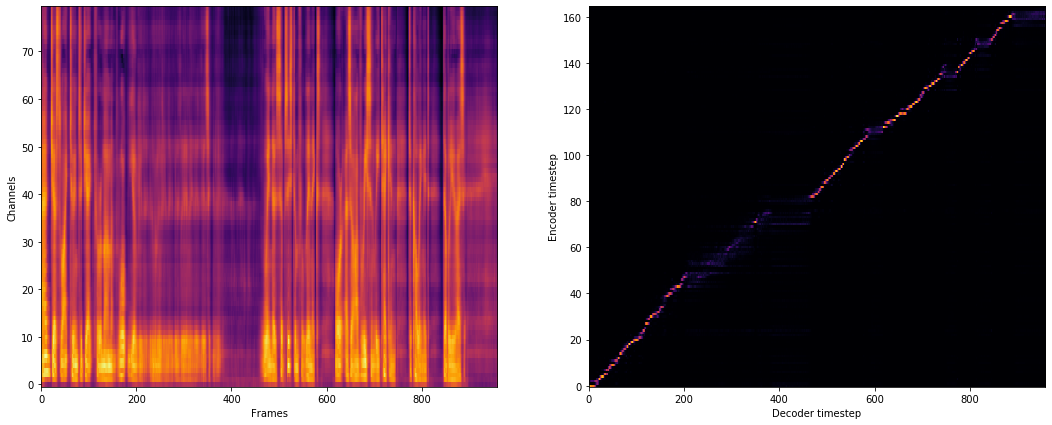

In [58]:
import matplotlib.pylab as pylab

alignment_graph_width = 1800
alignment_graph_height = 720
graph_scale = 1

def plot_data(data, info=None):
    %matplotlib inline
    fig, axes = pylab.subplots(1, len(data), figsize=(int(alignment_graph_width*graph_scale/100), int(alignment_graph_height * graph_scale / 100)))
    for i in range(len(data)):
        print(data[i].shape)
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none', cmap='inferno')
    axes[0].set(xlabel="Frames", ylabel="Channels")
    axes[1].set(xlabel="Decoder timestep", ylabel="Encoder timestep")
    fig.canvas.draw()
    pylab.show()

plot_data([
  mel[0].data.cpu().numpy(),
  alignments[0].data.cpu().numpy().T,
])

In [67]:
model.encoder.convolutions.requires_grad

ModuleAttributeError: 'ModuleList' object has no attribute 'requires_grad'

In [71]:
i = 0
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [73]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
for param in model.parameters():
    